In [1]:
using HierarchicalDriving
import POMDPs:initial_state
using POMDPToolbox
using Interact
using MCTS
using AutoViz
import ParticleFilters: obs_weight
import Base: ==, +, *, -, <, >, copy, Random, hash

In [2]:
HORIZON = 10
TIME_STEP = 0.3
lb_x = (AVG_HWY_VELOCITY - 5.0) * TIME_STEP * HORIZON
ub_x = (AVG_HWY_VELOCITY + 5.0) * TIME_STEP * HORIZON
p = LowLevelMDP(0.99,TIME_STEP, HORIZON,
                            HierarchicalDriving.RoadSegment((-100.0, 500.0),[0.0, LANE_WIDTH, 2.0 * LANE_WIDTH, 3.0 * LANE_WIDTH, 4.0 * LANE_WIDTH]),
                            CarPhysicalState((0.0, 1.0 * LANE_WIDTH/2.0, AVG_HWY_VELOCITY)),
                            (CarPhysicalState((lb_x, 3.0 * LANE_WIDTH/2.0 - 0.5, AVG_HWY_VELOCITY - 5)),
                             CarPhysicalState((ub_x, 3.0 * LANE_WIDTH/2.0 + 0.5, AVG_HWY_VELOCITY + 5))),
                            50.0, -500.0, -0.0, -5.0, -5.0, -1.0, HierarchicalDriving.getFrameList());


Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(6, nactions=1),"i",6,"6",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3",5=>"5"…)),Any[],Any[],true,"horizontal")

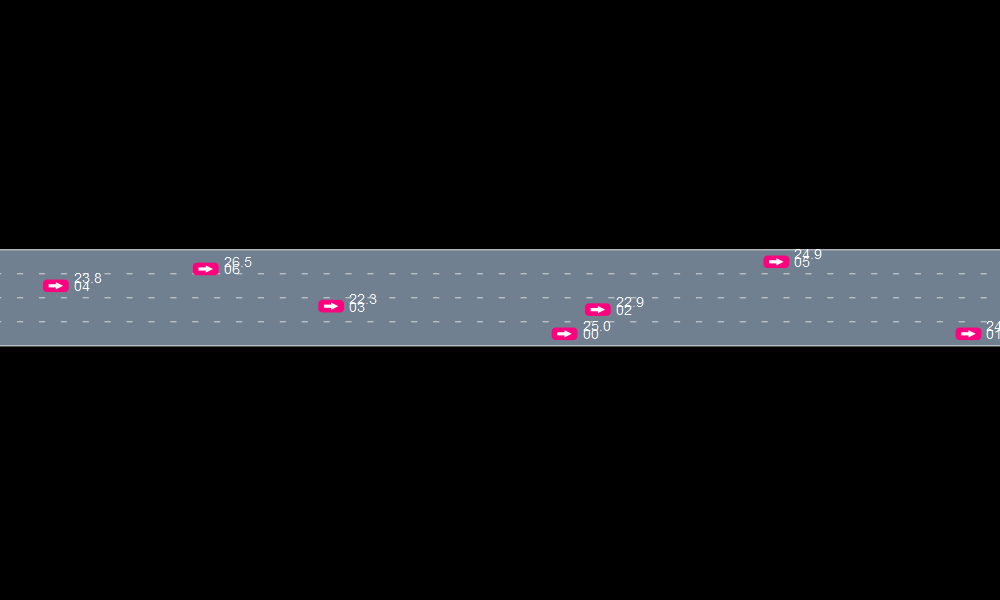

In [3]:
i = 34
#policy = RandomPolicy(p)
policy = subintentional_lowlevel_policy(p)
hr = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
hist = simulate(hr, p, policy)
@manipulate for i in 1:n_steps(hist)+1
    (p,state_hist(hist)[i],SceneOverlay[CarVelOverlay(), CarIDOverlay()])
end

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(6, nactions=1),"i",6,"6",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3",5=>"5"…)),Any[],Any[],true,"horizontal")

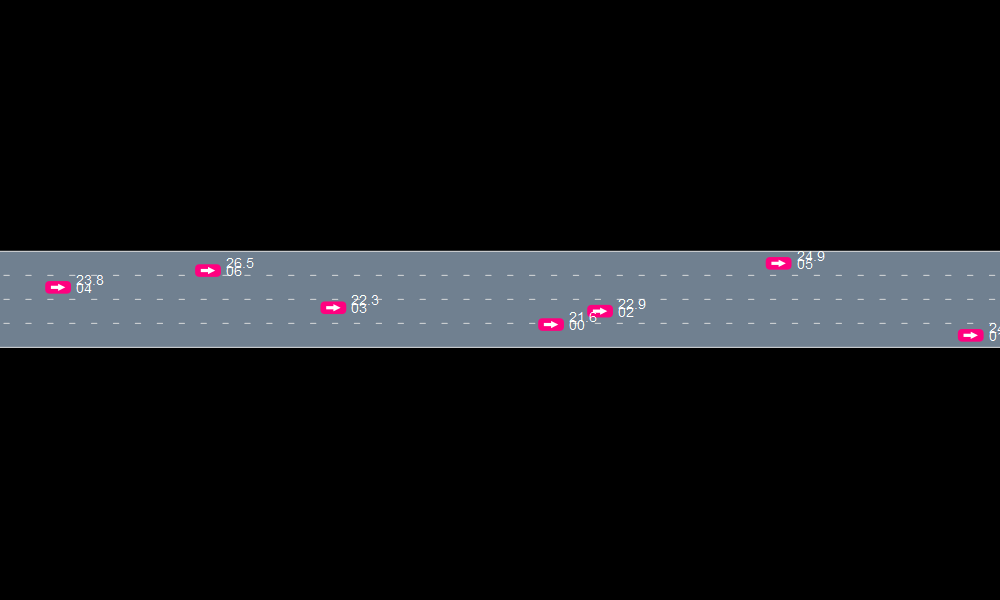

In [4]:
solver = DPWSolver(depth=p.HORIZON,
                           exploration_constant=10.0,
                           n_iterations=1_500,
                           k_action=10.0,
                           alpha_action=1/10,
                           k_state=5.0,
                           alpha_state=1/10,

                          )
policy1 = solve(solver, p)
hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
hist1 = simulate(hr1, p, policy1)
@manipulate for i in 1:n_steps(hist1)+1
    (p,state_hist(hist1)[i])
end

In [5]:
discounted_reward(hist)

45.67586237418204

In [6]:
discounted_reward(hist1)

34.123558845652454

In [15]:
function testing()
    n = 100
    sum = 0.0
    sum1 = 0.0
    numPositiveRnd = 0
    numPositiveMCTS = 0
    for i in 1:n
        #policy = RandomPolicy(p)
        policy = subintentional_lowlevel_policy(p)
        hr = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
        hist = simulate(hr, p, policy)

        solver = DPWSolver(depth=p.HORIZON,
                               exploration_constant=10.0,
                               n_iterations=1_500,
                               k_action=10.0,
                               alpha_action=1/10,
                               k_state=10.0,
                               alpha_state=1/10,
                               #estimate_value=RolloutEstimator(subintentional_policy(p))
                              )
        policy1 = solve(solver, p)
        hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
        hist1 = simulate(hr1, p, policy1)

        println(i, ",", discounted_reward(hist), ",", discounted_reward(hist1))
        sum += discounted_reward(hist)
        sum1+= discounted_reward(hist1)
        if discounted_reward(hist)>0
            numPositiveRnd += 1
        end
        if discounted_reward(hist1)>0
            numPositiveMCTS += 1
        end
    end
    println("Mean: ",sum/n,",", sum1/n)
    println("Success Rate: ", numPositiveRnd/n, ",", numPositiveMCTS/n)
end

testing (generic function with 1 method)

.


In [16]:
@time testing()

1,45.67586237418204,46.137234721396
2,45.67586237418204,46.137234721396
3,0.0,46.137234721396
4,0.0,46.137234721396
5,0.0,46.137234721396
6,0.0,46.137234721396
7,45.67586237418204,46.137234721396
8,45.67586237418204,46.137234721396
9,45.67586237418204,46.137234721396
10,45.67586237418204,46.137234721396
11,45.67586237418204,46.137234721396
12,45.67586237418204,46.137234721396
13,45.67586237418204,45.67586237418204
14,45.67586237418204,46.137234721396
15,0.0,46.137234721396
16,0.0,46.137234721396
17,0.0,45.67586237418204
18,45.67586237418204,46.137234721396
19,45.67586237418204,45.67586237418204
20,0.0,40.87288232418204
21,45.67586237418204,46.137234721396
22,0.0,45.67586237418204
23,45.67586237418204,46.137234721396
24,45.67586237418204,46.137234721396
25,45.67586237418204,45.67586237418204
26,45.67586237418204,45.67586237418204
27,0.0,45.67586237418204
28,0.0,41.334254671395996
29,0.0,45.67586237418204
30,0.0,46.137234721396
31,0.0,46.137234721396
32,0.0,46.137234721396
33,45.67586237

In [5]:
HORIZON = 60
TIME_STEP = 0.3
lb_x = (AVG_HWY_VELOCITY - 5.0) * TIME_STEP * HORIZON
ub_x = (AVG_HWY_VELOCITY + 5.0) * TIME_STEP * HORIZON
p2 = SimulationMDP(0.9, 0.2, 40,
                                  HierarchicalDriving.RoadSegment((-100.0, 500.0),[0.0, LANE_WIDTH, 2.0 * LANE_WIDTH, 3.0 * LANE_WIDTH, 4.0 * LANE_WIDTH]),
                                  CarPhysicalState((0.0, 1.0 * LANE_WIDTH/2.0, AVG_HWY_VELOCITY)),
                                  (CarPhysicalState((425.0, 7.0 * LANE_WIDTH/2.0 - 0.5, AVG_HWY_VELOCITY - 0.5)),
                                   CarPhysicalState((500.0, 7.0 * LANE_WIDTH/2.0 + 0.5, AVG_HWY_VELOCITY + 0.5))),
                                  HierarchicalDriving.getFrameList() );


Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(31, nactions=1),"i",31,"31",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",39=>"39",46=>"46",25=>"25",55=>"55",42=>"42",29=>"29",58=>"58",59=>"59"…)),Any[],Any[],true,"horizontal")

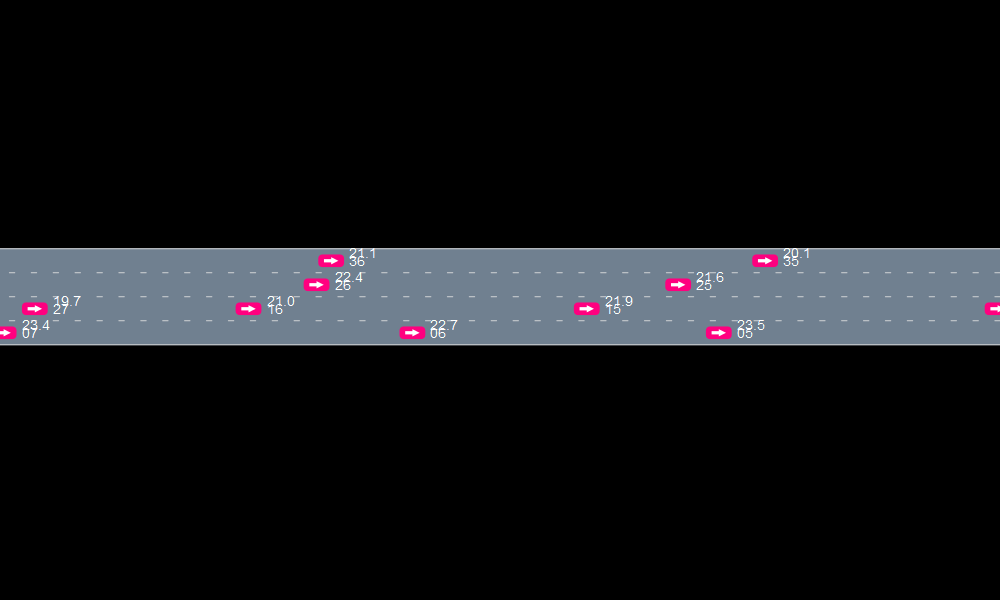

In [10]:
j=1
policy = subintentional_simulation_policy(p2)
hr = HistoryRecorder(max_steps = HORIZON, rng = MersenneTwister(j))
hist = simulate(hr, p2, policy)
@manipulate for i in 1:n_steps(hist)+1
    (p2,state_hist(hist)[i],SceneOverlay[CarVelOverlay(), CarIDOverlay()])
end

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(6, nactions=1),"i",6,"6",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3",5=>"5"…)),Any[],Any[],true,"horizontal")

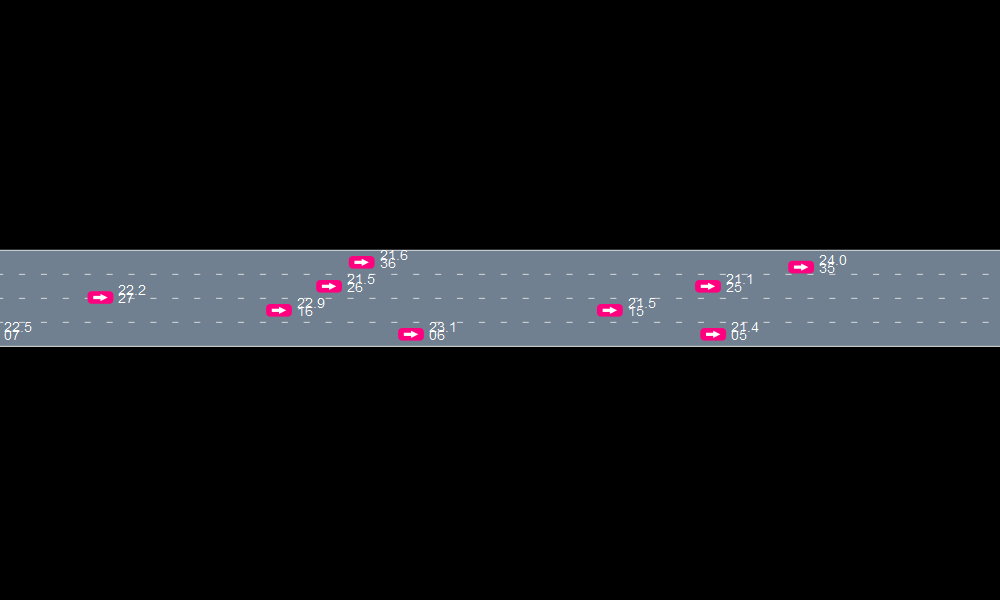

In [11]:
solver = DPWSolver(depth=p.HORIZON,
                           exploration_constant=10.0,
                           n_iterations=1_500,
                           k_action=10.0,
                           alpha_action=1/10,
                           k_state=5.0,
                           alpha_state=1/10,

                          )
policy1 = solve(solver, p2)
hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(j))
hist1 = simulate(hr1, p2, policy1)
@manipulate for i in 1:n_steps(hist1)+1
    (p,state_hist(hist1)[i])
end